<a href="https://colab.research.google.com/github/wayaadhyasta/transaksi_perhiasan/blob/main/transaksi_perhiasan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import pandas as pd

# Baca file CSV
df = pd.read_csv('/content/drive/MyDrive/transaksi_perhiasan.csv')

# Lihat 5 data teratas
df.head()


,ID,Age,Income,Outcome,Items
0,hl7es9bi,21,25,35,"Anting perak, Gelang perak"
1,imfnjkpq,45,90,88,"Cincin emas, Anting emas, Kalung emas"
2,zd8vtvrj,32,65,60,"Kalung emas, Liontin"
3,8sfol69r,23,22,28,Cincin perak
4,91sqrefo,55,110,95,"Set perhiasan berlian, Anting berilian"


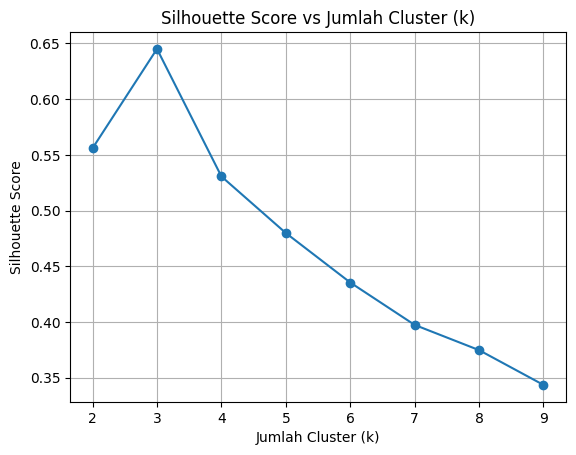

In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Ambil fitur numerik
X = df[['Age', 'Income', 'Outcome']]

# Standarisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Mencari nilai k-optimum
silhouette_scores = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Visualisasi Silhouette Score
plt.plot(K, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Jumlah Cluster (k)")
plt.xlabel("Jumlah Cluster (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Ambil k terbaik
optimal_k = K[silhouette_scores.index(max(silhouette_scores))]
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)


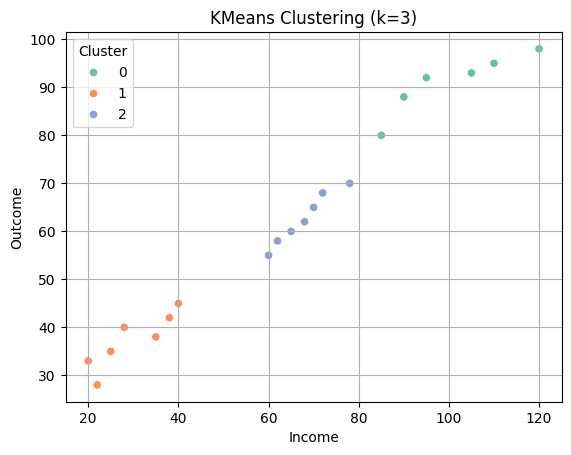

Cluster 0
 - Rata-rata Usia     : 49.67
 - Rata-rata Income   : 100.83
 - Rata-rata Outcome  : 91.00
 - Jumlah Pelanggan   : 6

Cluster 1
 - Rata-rata Usia     : 22.00
 - Rata-rata Income   : 29.71
 - Rata-rata Outcome  : 37.29
 - Jumlah Pelanggan   : 7

Cluster 2
 - Rata-rata Usia     : 33.29
 - Rata-rata Income   : 67.86
 - Rata-rata Outcome  : 62.57
 - Jumlah Pelanggan   : 7



In [3]:
import seaborn as sns

# Visualisasi hasil clustering
sns.scatterplot(data=df, x='Income', y='Outcome', hue='Cluster', palette='Set2')
plt.title(f'KMeans Clustering (k={optimal_k})')
plt.xlabel("Income")
plt.ylabel("Outcome")
plt.grid(True)
plt.show()

# Interpretasi Bisnis
for i in range(optimal_k):
    cluster_data = df[df['Cluster'] == i]
    print(f"Cluster {i}")
    print(f" - Rata-rata Usia     : {cluster_data['Age'].mean():.2f}")
    print(f" - Rata-rata Income   : {cluster_data['Income'].mean():.2f}")
    print(f" - Rata-rata Outcome  : {cluster_data['Outcome'].mean():.2f}")
    print(f" - Jumlah Pelanggan   : {len(cluster_data)}\n")


In [4]:
!pip install mlxtend --quiet

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules

# Format transaksi untuk FP-Growth
transactions = [item.lower().split(", ") for item in df['Items']]
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)

# FP-Growth
frequent_itemsets = fpgrowth(df_trans, min_support=0.1, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Top 5 lift tertinggi
top5_lift = rules.sort_values(by='lift', ascending=False).head(5)
top5_lift[['antecedents', 'consequents', 'support', 'confidence', 'lift']]


,antecedents,consequents,support,confidence,lift
4,"(kalung emas, cincin emas)",(anting emas),0.10,1.000000,6.666667
7,(anting emas),"(kalung emas, cincin emas)",0.10,0.666667,6.666667
9,(cincin perak),(anting perak),0.15,0.750000,3.750000
10,(anting perak),(cincin perak),0.15,0.750000,3.750000
6,"(cincin emas, anting emas)",(kalung emas),0.10,1.000000,2.857143


In [5]:
# Tampilkan insight rule
for idx, row in top5_lift.iterrows():
    ant = ', '.join(row['antecedents'])
    con = ', '.join(row['consequents'])
    print(f"Jika pelanggan membeli [{ant}], maka besar kemungkinan membeli [{con}] "
          f"(confidence={row['confidence']:.2f}, lift={row['lift']:.2f})")


Jika pelanggan membeli [kalung emas, cincin emas], maka besar kemungkinan membeli [anting emas] (confidence=1.00, lift=6.67)
Jika pelanggan membeli [anting emas], maka besar kemungkinan membeli [kalung emas, cincin emas] (confidence=0.67, lift=6.67)
Jika pelanggan membeli [cincin perak], maka besar kemungkinan membeli [anting perak] (confidence=0.75, lift=3.75)
Jika pelanggan membeli [anting perak], maka besar kemungkinan membeli [cincin perak] (confidence=0.75, lift=3.75)
Jika pelanggan membeli [cincin emas, anting emas], maka besar kemungkinan membeli [kalung emas] (confidence=1.00, lift=2.86)
